In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format
import os
import itertools

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict


%matplotlib inline

In [2]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Activation
from keras.optimizers import SGD, Adam

In [3]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [4]:
def convertToOneClass(y):
    if y == 1:
        return -1
    return 1

In [5]:
def convertlabel(sample):
    if "Botnet" in sample: return 1
    else: return 0

In [6]:
def is_hex(s):
    try:
        int(s, 16)
        return True
    except ValueError:
        return False

def convertHexInSport(port):
    if str(int(port, 16)) != port:
        return int(port, 16)

    return int(port)


In [7]:
def standardize(data, saved_dict, scaler):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [9]:
test_files = ['capture20110811.binetflow','capture20110810.binetflow','capture20110816-2.binetflow','capture20110816.binetflow','capture20110818-2.binetflow','capture20110819.binetflow']

In [10]:
pathdir = '../Mine/CTU-13-Dataset'
filenames = os.listdir(pathdir)
train_files = []
for file in filenames:
    if file not in test_files: train_files.append(file)

In [11]:
train_files

['capture20110816-3.binetflow',
 'capture20110815-3.binetflow',
 'capture20110818.binetflow',
 'capture20110817.binetflow',
 'capture20110815.binetflow',
 'capture20110815-2.binetflow',
 'capture20110812.binetflow']

In [12]:
trainBotnames = ['Murlo', 'Virut', 'Rbot', 'Neris', 'Rbot', 'Virut', 'Rbot']

In [13]:
trainBotnames

['Murlo', 'Virut', 'Rbot', 'Neris', 'Rbot', 'Virut', 'Rbot']

In [14]:
testBotnames = ['Neris', 'Neris', 'Sogou', 'DonBot', 'Rbot', 'NSIS']

In [15]:
def loadData(trainfiles, trainBotnames):
    data = {}
    for name in set(trainBotnames):
        data[name] = pd.DataFrame()
    for file, name in zip(train_files, trainBotnames):
        if data[name].empty: 
            print("Create new botnet")
            data[name] = pd.read_csv(pathdir + '/' + file)
        else: 
            print("Append botnet")
            data[name] = data[name].append(pd.read_csv(pathdir + '/' + file))
    return data

In [16]:
data = loadData(train_files, trainBotnames)

Create new botnet
Create new botnet
Create new botnet
Create new botnet
Append botnet
Append botnet
Append botnet


In [25]:
data

,dur,proto,sport,dir,dport,stos,dtos,totpkts,totbytes,srcbytes,target,label
0,2458.846924,tcp,6006,->,1091,0.0,0.0,8,488,248,0,Virut
1,2452.237549,tcp,6192,->,1091,0.0,0.0,8,488,248,0,Virut
2,2451.636475,tcp,6200,->,1091,0.0,0.0,8,488,248,0,Virut
3,2467.759033,tcp,6451,->,1091,0.0,0.0,8,488,248,0,Virut
4,2470.564453,tcp,6519,->,1091,0.0,0.0,8,488,248,0,Virut
...,...,...,...,...,...,...,...,...,...,...,...,...
265487,9.014144,tcp,10505,->,34,0.0,0.0,3,186,186,3,Rbot
265488,9.013652,tcp,10512,->,34,0.0,0.0,3,186,186,3,Rbot
265489,0.000000,udp,311,->,283494,0.0,0.0,1,104,104,3,Rbot
265490,0.000000,udp,311,->,276614,0.0,0.0,1,104,104,3,Rbot


In [18]:
def preprocess(dataFrame):
    for key in data:
        data[key].columns = data[key].columns.str.lower()    
        data[key]['target'] = data[key]['label'].apply(convertlabel)
        data[key] = data[key][data[key]['target'] == 1]
        data[key].drop(['starttime', 'srcaddr', 'dstaddr', 'state'], axis=1, inplace=True)
        data[key].drop(['label'], axis=1, inplace=True)
        data[key].reset_index(inplace=True)
        data[key].drop(data[key][data[key]['stos'] == 192.0].index)
        data[key].reset_index(inplace=True)
        data[key]['stos'] = data[key].stos.fillna(value=0.0)
        data[key]['dtos'] = data[key].dtos.fillna(value=0.0)
        data[key].dropna(inplace=True)
        data[key]['sport'] = data[key]['sport'].apply(convertHexInSport)
        data[key]['dport'] = data[key]['dport'].apply(convertHexInSport)
        data[key].drop(columns='level_0',axis=1, inplace=True)
        data[key].drop(columns='index',axis=1, inplace=True)
    for index, key in enumerate(data):
        data[key]['label'] = key
        data[key]['target'].replace(1, index, inplace=True)        
    df = pd.DataFrame()
    for key in data:
        df = df.append(data[key], ignore_index=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [19]:
data=preprocess(data)
data.head()

,dur,proto,sport,dir,dport,stos,dtos,totpkts,totbytes,srcbytes,target,label
0,2458.846924,tcp,6006,->,1091,0.0,0.0,8,488,248,0,Virut
1,2452.237549,tcp,6192,->,1091,0.0,0.0,8,488,248,0,Virut
2,2451.636475,tcp,6200,->,1091,0.0,0.0,8,488,248,0,Virut
3,2467.759033,tcp,6451,->,1091,0.0,0.0,8,488,248,0,Virut
4,2470.564453,tcp,6519,->,1091,0.0,0.0,8,488,248,0,Virut


In [24]:
data

,dur,proto,sport,dir,dport,stos,dtos,totpkts,totbytes,srcbytes,target,label
0,2458.846924,tcp,6006,->,1091,0.0,0.0,8,488,248,0,Virut
1,2452.237549,tcp,6192,->,1091,0.0,0.0,8,488,248,0,Virut
2,2451.636475,tcp,6200,->,1091,0.0,0.0,8,488,248,0,Virut
3,2467.759033,tcp,6451,->,1091,0.0,0.0,8,488,248,0,Virut
4,2470.564453,tcp,6519,->,1091,0.0,0.0,8,488,248,0,Virut
...,...,...,...,...,...,...,...,...,...,...,...,...
265487,9.014144,tcp,10505,->,34,0.0,0.0,3,186,186,3,Rbot
265488,9.013652,tcp,10512,->,34,0.0,0.0,3,186,186,3,Rbot
265489,0.000000,udp,311,->,283494,0.0,0.0,1,104,104,3,Rbot
265490,0.000000,udp,311,->,276614,0.0,0.0,1,104,104,3,Rbot


In [35]:
data.target.value_counts()

1    184987
0     40904
3     33474
2      6127
Name: target, dtype: int64

In [36]:
def normalize_data(data):
    num_col = [ 'dur', 'sport', 'dport', 'totpkts', 'totbytes', 'srcbytes']
    cat_col = list(set(data.columns) - set(num_col))
    
    
    cat_col.remove('target')
    cat_col.remove('label')
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(data[num_col])
    data[num_col] = scaler.transform(data[num_col])
    
    pickle.dump(scaler, open('scaletrainBotnet.pkl', 'wb'))
    
    stos_ = OneHotEncoder()
    dtos_ = OneHotEncoder()
    dir_ = OneHotEncoder()
    proto_ = OneHotEncoder()

    ohe_stos = stos_.fit(data.stos.values.reshape(-1,1))
    ohe_dtos = dtos_.fit(data.dtos.values.reshape(-1,1))
    ohe_dir = dir_.fit(data.dir.values.reshape(-1,1))
    ohe_proto = proto_.fit(data.proto.values.reshape(-1,1))
    
    pickle.dump(ohe_stos, open('ohe_stosTrainBotnet.pkl', 'wb'))
    pickle.dump(ohe_dtos, open('ohe_dtosTrainBotnet.pkl', 'wb'))
    pickle.dump(ohe_dir, open('ohe_dirTrainBotnet.pkl', 'wb'))
    pickle.dump(ohe_proto, open('ohe_protoTrainBotnet.pkl', 'wb'))
    
    for col, encoding in zip(['stos', 'dtos', 'dir', 'proto'], [ohe_stos, ohe_dtos, ohe_dir, ohe_proto]):
        x = encoding.transform(data[col].values.reshape(-1,1))
        tmp_df = pd.DataFrame(x.toarray(), dtype='int64', columns=[col+'_'+str(i) for i in encoding.categories_[0]])
        data = pd.concat([data.drop(col, axis=1), tmp_df], axis=1)
    data = data.sample(frac=1).reset_index(drop=True)
    target = data['target']
    label = data['label']
    data.drop('target', axis=1, inplace=True)
    data.drop('label', axis=1, inplace=True)
    return data,target, label

In [37]:
X, y , label = normalize_data(data)

In [43]:
label.value_counts()

Neris    184987
Virut     40904
Rbot      33474
Murlo      6127
Name: label, dtype: int64

In [42]:
y.value_counts()

1    184987
0     40904
3     33474
2      6127
Name: target, dtype: int64

In [38]:
print(X.shape)
print(y.shape)

(265492, 14)
(265492,)


In [44]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3)

In [45]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(185844, 14)
(79648, 14)
(185844,)
(79648,)


In [46]:
pickle.dump((trainX, testX, trainY, testY), open("dataBotNetMLP.pkl", "wb"))

In [47]:
def getmodel(inputShape):
    inputs = Input(shape=inputShape)
    x = Dense(128)(inputs)
    x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
#     x = Dense(1024)(x)
#     x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)   
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dense(4)(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [48]:
model = getmodel(14)

In [49]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [50]:
trainY

198352    1
240731    0
4587      0
233334    3
150936    1
         ..
119879    1
259178    3
131932    1
146867    1
121958    1
Name: target, Length: 185844, dtype: int64

In [51]:
encY = OneHotEncoder()
trainY = encY.fit_transform(trainY.values.reshape(-1,1))

In [52]:
trainY = trainY.toarray()
trainY

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [53]:
history = model.fit(trainX,trainY,epochs=30,validation_split=0.2,batch_size=128)

Epoch 1/30
1162/1162 [==============================] - 14s 11ms/step - loss: 0.8198 - accuracy: 0.6493 - val_loss: 0.6121 - val_accuracy: 0.7814
Epoch 2/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.6290 - accuracy: 0.7747 - val_loss: 0.6494 - val_accuracy: 0.7630
Epoch 3/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.6355 - accuracy: 0.7664 - val_loss: 0.6122 - val_accuracy: 0.7774
Epoch 4/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.6151 - accuracy: 0.7759 - val_loss: 0.6294 - val_accuracy: 0.7631
Epoch 5/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.6107 - accuracy: 0.7716 - val_loss: 0.6223 - val_accuracy: 0.7634
Epoch 6/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.6057 - accuracy: 0.7758 - val_loss: 0.5939 - val_accuracy: 0.7816
Epoch 7/30
1162/1162 [==============================] - 13s 11ms/step - loss: 0.5949 - accuracy: 0.7812 - val_loss: 0.5976 -

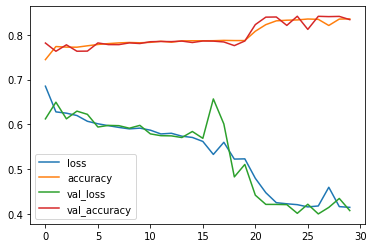

In [54]:
historyPD = pd.DataFrame(history.history)
historyPD.plot()

In [55]:
model.save('MLPv1.h5')

In [117]:
model.save('MLP.h5')

# Evaluation on Training set

In [56]:
predY = model.predict(trainX)

In [57]:
temp1 = np.argmax(predY, axis=1).reshape(-1,1)

In [58]:
trainY

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [59]:
temp2 = np.array([np.where(r==1)[0][0] for r in trainY]).reshape(-1,1)

In [61]:
temp2

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [62]:
temp1.shape, temp2.shape

((185844, 1), (185844, 1))

In [66]:
np.unique(temp2, return_counts=True)

(array([0, 1, 2, 3]), array([ 28534, 129399,   4322,  23589]))

In [63]:
print(confusion_matrix(temp2, temp1))

[[ 16731   7693      4   4106]
 [  5708 113171      8  10512]
 [     0     93   4229      0]
 [     5   2669      0  20915]]


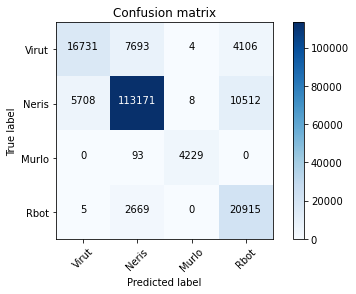

In [67]:
plot_confusion_matrix(confusion_matrix(temp2, temp1), classes=['Virut', 'Neris', 'Murlo', 'Rbot'])

In [68]:
print(classification_report(temp2, temp1))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66     28534
           1       0.92      0.87      0.89    129399
           2       1.00      0.98      0.99      4322
           3       0.59      0.89      0.71     23589

    accuracy                           0.83    185844
   macro avg       0.81      0.83      0.81    185844
weighted avg       0.85      0.83      0.84    185844



# Evaluation on Test set


In [69]:
predY_test = model.predict(testX)

In [70]:
temp1 = np.argmax(predY_test, axis=1).reshape(-1,1)

In [71]:
temp2 = testY.values.reshape(-1,1)

In [72]:
temp1.shape, temp2.shape

((79648, 1), (79648, 1))

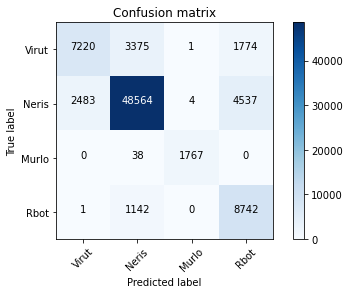

In [74]:
plot_confusion_matrix(confusion_matrix(temp2, temp1), classes=['Virut', 'Neris', 'Murlo', 'Rbot'])

In [75]:
print(classification_report(temp2, temp1))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65     12370
           1       0.91      0.87      0.89     55588
           2       1.00      0.98      0.99      1805
           3       0.58      0.88      0.70      9885

    accuracy                           0.83     79648
   macro avg       0.81      0.83      0.81     79648
weighted avg       0.85      0.83      0.83     79648



In [76]:
print(accuracy_score(temp2, temp1))

0.8323247288067497
